In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import Callback, ModelCheckpoint
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.models import Sequential, load_model
from keras.utils import np_utils
import keras.backend as K

# Keras implementation of Phased LSTM [https://arxiv.org/abs/1610.09513], from NIPS 2016.
# To install run: `pip install phased_lstm_keras`
from phased_lstm_keras.PhasedLSTM import PhasedLSTM as PLSTM

Using TensorFlow backend.


In [2]:
# 数据集读取及预处理
def read_dataset(filepath):
    print(filepath)
    
    #读取原始数据集，保留原始数据文件，日期格式转换，设置日期为索引列
    data_raw = pd.read_csv(filepath_or_buffer=filepath, usecols=['DATE','TEMP','PRICE','SALES','COUPON','HOLIDAY'], 
                           parse_dates={'Timeline':['DATE']}, index_col='Timeline')

    print('shape before dropna:', data_raw.shape)

    #去除qty值为NaN的行，*另可考虑填充均值
    data_raw = data_raw.dropna()
    #pandas 0.20版本，sort() => sort_index()，按日期排序
    data_raw = data_raw.sort_index()

    print('shape after dropna:', data_raw.shape)    
    print(data_raw.describe())
    
    return data_raw


# 建立训练和测试数据集
def create_dataset(dataset, seq_len=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_len-1):
        dataX.append(dataset[i: i + seq_len])
        dataY.append(dataset[:,2][i + seq_len])
            
    return np.array(dataX).astype('float64'), np.array(dataY).astype('float64')

In [3]:
# 特征缩放 - 调节比例
def feature_rescaling(mat,col):
    data = mat
    data[:,col]=(data[:,col]-data[:,col].min())/(data[:,col].max()-data[:,col].min()) 
    return data

def feature_inverse_rescaling(mat,col,min,max):
    data = mat
    data[:,col]=data[:,col]*(max-min)+min
    return data

# 特征缩放 - 标准化
def feature_standardization(mat,col):
    data = mat
    data[:,col]=(data[:,col]-data[:,col].mean())/data[:,col].std()
    return data
    
def feature_inverse_standardization(mat,col,mean,std):
    data = mat
    data[:,col]=data[:,col]*std+mean
    return data

In [4]:
# 用于在训练过程中记录accuracy和loss的变化值
class MapeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get(mape))


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        

def mape(y_true, y_pred):
    # 此处如果/y_true, 在训练过程中，y_true会变成0，导致inf，因为数据集中最小值归一化后变成了0
    return abs(y_true-y_pred)

In [5]:
# 建立Phased LSTM模型
def bulid_model_plstm(layers):
    model = Sequential()
    
    model.add(PLSTM(
        input_shape=(layers[1], layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(PLSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=layers[3], activation='linear'))

    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[mape])
    model.summary()

    return model


# 建立标准LSTM模型
def bulid_model_lstm(layers):
    model = Sequential()
    
    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=layers[3], activation='linear'))

    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[mape])
    model.summary()

    return model

train_data_mv_multi.csv
shape before dropna: (2445, 5)
shape after dropna: (2358, 5)
              TEMP        PRICE        SALES       COUPON      HOLIDAY
count  2358.000000  2358.000000  2358.000000  2358.000000  2358.000000
mean     58.249724     5.954198   186.195081     0.025021     0.019508
std       7.086737     0.161023    75.433074     0.156223     0.138332
min      35.100000     4.980164    52.000000     0.000000     0.000000
25%      53.100000     5.990000   143.000000     0.000000     0.000000
50%      59.000000     5.990000   172.000000     0.000000     0.000000
75%      63.000000     5.990000   210.000000     0.000000     0.000000
max      81.050000     5.996452   901.000000     1.000000     1.000000
            TEMP  PRICE  SALES  COUPON  HOLIDAY
Timeline                                       
2010-09-01  75.2   5.79  222.0     0.0        0
2010-09-02  74.9   5.79  207.0     0.0        0
2010-09-03  66.0   5.79  292.0     0.0        0
2010-09-04  62.1   5.79  221.0     0

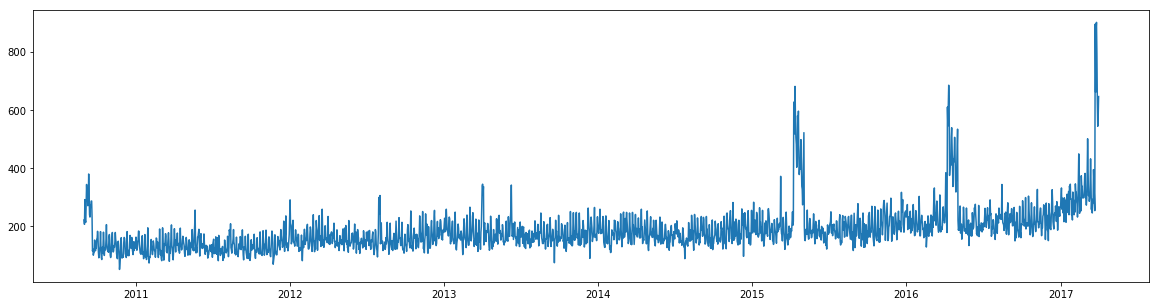

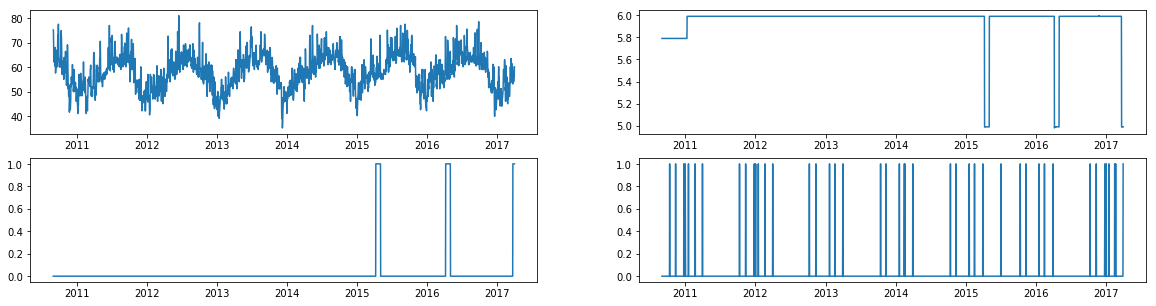

In [6]:
if __name__ == "__main__":

    # 读取原始数据集，数据可视化
    train_raw = read_dataset('train_data_mv_multi.csv')
    
    print(train_raw[:5])
    
    plt.figure(figsize=(20,5))
    plt.plot(train_raw['SALES'])
    plt.show()
    
    fig,ax = plt.subplots(2,2,figsize=[20,5])
    ax[0,0].plot(train_raw['TEMP'])
    ax[0,1].plot(train_raw['PRICE'])
    
    ax[1,0].plot(train_raw['COUPON'])
    ax[1,1].plot(train_raw['HOLIDAY'])
   
    plt.show()

test_data_mv_multi.csv
shape before dropna: (120, 5)
shape after dropna: (119, 5)
             TEMP       PRICE       SALES      COUPON  HOLIDAY
count  119.000000  119.000000  119.000000  119.000000    119.0
mean    63.259664    5.855575  317.411765    0.134454      0.0
std      5.977547    0.342593  108.731859    0.342582      0.0
min     50.000000    4.990000  168.000000    0.000000      0.0
25%     59.000000    5.990000  253.000000    0.000000      0.0
50%     62.550000    5.990000  281.000000    0.000000      0.0
75%     66.450000    5.990000  338.000000    0.000000      0.0
max     82.950000    5.993484  718.000000    1.000000      0.0
             TEMP  PRICE  SALES  COUPON  HOLIDAY
Timeline                                        
2017-04-01  62.95   4.99  590.0     1.0        0
2017-04-02  59.00   4.99  664.0     1.0        0
2017-04-03  56.90   4.99  617.0     1.0        0
2017-04-04  60.55   4.99  486.0     1.0        0
2017-04-05  62.55   4.99  516.0     1.0        0


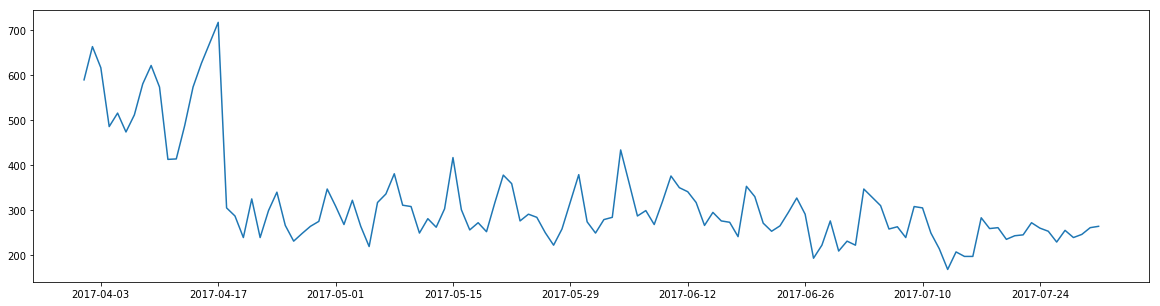

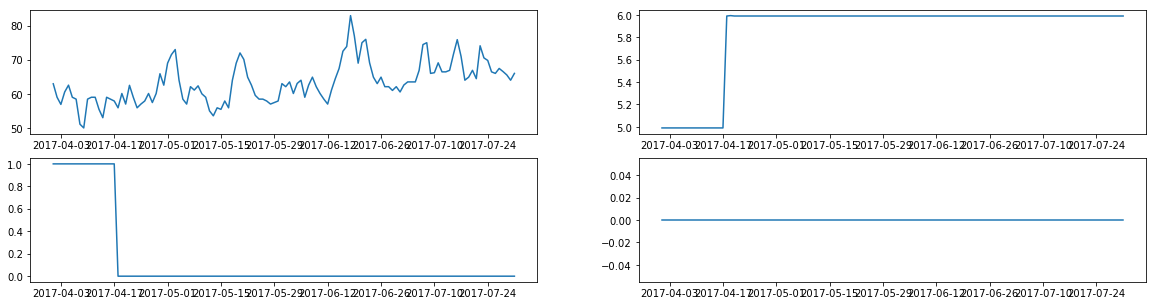

In [7]:
    test_raw = read_dataset('test_data_mv_multi.csv')
    
    print(test_raw[:5])
    
    plt.figure(figsize=(20,5))
    plt.plot(test_raw['SALES'])
    plt.show()
    
    fig,ax = plt.subplots(2,2,figsize=[20,5])
    ax[0,0].plot(test_raw['TEMP'])
    ax[0,1].plot(test_raw['PRICE'])
    
    ax[1,0].plot(test_raw['COUPON'])
    ax[1,1].plot(test_raw['HOLIDAY'])
   
    plt.show()

In [8]:
    # 数据归一化处理
    
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #train = scaler.fit_transform(train_raw)
    #test = scaler.fit_transform(test_raw)    
    
    train = np.mat(train_raw)
    test = np.mat(test_raw)
    
    # 记录sales的均值和标准差，用于预测后的反向缩放
    train_min = train[:,2].min()
    train_max = train[:,2].max()
    test_min = test[:,2].min()
    test_max = test[:,2].max()
        
    train = feature_rescaling(train,2)
    test = feature_rescaling(test,2)
    
    train = feature_rescaling(train,0)
    test = feature_rescaling(test,0)
    
    train[:,1] = train[:,1]/6
    test[:,1] = test[:,1]/6
    
    
    print(train.shape, 'min:', train_min ,'max:', train_max)
    print(train[:5])
    
    print(test.shape, 'min:', test_min ,'max:', test_max)
    print(test[:5])

(2358, 5) min: 52.0 max: 901.0
[[ 0.8726877   0.965       0.20023557  0.          0.        ]
 [ 0.86615887  0.965       0.18256773  0.          0.        ]
 [ 0.67247008  0.965       0.28268551  0.          0.        ]
 [ 0.58759521  0.965       0.19905771  0.          0.        ]
 [ 0.6289445   0.965       0.19081272  0.          0.        ]]
(119, 5) min: 168.0 max: 718.0
[[ 0.39301973  0.83166667  0.76727273  1.          0.        ]
 [ 0.27314112  0.83166667  0.90181818  1.          0.        ]
 [ 0.20940819  0.83166667  0.81636364  1.          0.        ]
 [ 0.32018209  0.83166667  0.57818182  1.          0.        ]
 [ 0.38088012  0.83166667  0.63272727  1.          0.        ]]


In [9]:
    seq_len = 30
    
    train = np.array(train).astype(float)
    
    trainX, trainY = create_dataset(train, seq_len)
    
    trainX = np.reshape(trainX, (trainX.shape[0], seq_len, trainX.shape[2]))
    trainY = np.reshape(trainY, (trainY.shape[0], 1))
    
    print('trainset after resharp')
    print('X shape', trainX.shape,'\n', trainX[:1])
    print('Y shape', trainY.shape,'\n', trainY[:1])
    

trainset after resharp
X shape (2327, 30, 5) 
 [[[ 0.8726877   0.965       0.20023557  0.          0.        ]
  [ 0.86615887  0.965       0.18256773  0.          0.        ]
  [ 0.67247008  0.965       0.28268551  0.          0.        ]
  [ 0.58759521  0.965       0.19905771  0.          0.        ]
  [ 0.6289445   0.965       0.19081272  0.          0.        ]
  [ 0.6289445   0.965       0.34393404  0.          0.        ]
  [ 0.60718172  0.965       0.29681979  0.          0.        ]
  [ 0.55168662  0.965       0.30742049  0.          0.        ]
  [ 0.71599565  0.965       0.25795053  0.          0.        ]
  [ 0.71599565  0.965       0.28150766  0.          0.        ]
  [ 0.58759521  0.965       0.38633687  0.          0.        ]
  [ 0.48857454  0.965       0.30388693  0.          0.        ]
  [ 0.52013058  0.965       0.22143698  0.          0.        ]
  [ 0.53210011  0.965       0.21201413  0.          0.        ]
  [ 0.67247008  0.965       0.25912839  0.          0.   

In [10]:
    test = np.array(test).astype(float)
    
    test_addon = np.concatenate((train[len(train)-seq_len:len(train)], test))
    
    print(test_addon.shape)
    
    testX, testY = create_dataset(test_addon, seq_len)
    
    testX = np.reshape(testX, (testX.shape[0], seq_len, testX.shape[2]))
    testY = np.reshape(testY, (testY.shape[0], 1))
    
    print('testset after resharp')
    print('X shape', testX.shape,'\n', testX[:1])
    print('Y shape', testY.shape,'\n', testY[:1])

(149, 5)
testset after resharp
X shape (118, 30, 5) 
 [[[ 0.40152339  0.99833333  0.26030624  0.          0.        ]
  [ 0.35799782  0.99833333  0.28504122  0.          0.        ]
  [ 0.39173014  0.99833333  0.38987044  0.          0.        ]
  [ 0.28073993  0.99833333  0.52885748  0.          0.        ]
  [ 0.30250272  0.99833333  0.39693757  0.          0.        ]
  [ 0.36779108  0.99833333  0.2991755   0.          0.        ]
  [ 0.45266594  0.99833333  0.30388693  0.          0.        ]
  [ 0.52013058  0.99833333  0.27561837  0.          0.        ]
  [ 0.54406964  0.99833333  0.28975265  0.          0.        ]
  [ 0.49619151  0.99833333  0.34275618  0.          0.        ]
  [ 0.40261153  0.99833333  0.44758539  0.          0.        ]
  [ 0.61806311  0.99833333  0.34275618  0.          0.        ]
  [ 0.59738847  0.99833333  0.2426384   0.          0.        ]
  [ 0.52013058  0.99833333  0.28504122  0.          0.        ]
  [ 0.49619151  0.99833333  0.22850412  0.        

In [11]:
    batch_size = 16
    nb_epoch = 25
    is_train = True
    
    # 训练PLSTM网络    
    # 输入维度 [n, layer1 seq_len, layer2 seq_len, out]
    model_PLSTM = bulid_model_plstm([5, seq_len, seq_len*2, 1])
    
    mape_PLSTM = MapeHistory()
    loss_PLSTM = LossHistory()
        
    #acc_LSTM = AccHistory()
    loss_PLSTM = LossHistory()
    
    checkpoint_fixed_name = ModelCheckpoint("model_plstm_multi_best_e{epoch:02d}-{val_loss:.4f}.hd5", 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)
    
    if is_train:
        model_PLSTM.fit(trainX, trainY, epochs=nb_epoch, batch_size=batch_size,
                       validation_split=0.05, callbacks=[loss_PLSTM, mape_PLSTM, checkpoint_fixed_name])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
phased_lstm_1 (PhasedLSTM)   (None, 30, 30)            4410      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
phased_lstm_2 (PhasedLSTM)   (None, 60)                22020     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 26,491
Trainable params: 26,491
Non-trainable params: 0
_________________________________________________________________
Train on 2210 samples, validate on 117 samples
Epoch 1/25
2210/2210 [==============================] - 27s - loss: 0.0068 - mape: 0.0546 -

2210/2210 [==============================] - 25s - loss: 0.0020 - mape: 0.0308 - val_loss: 0.0096 - val_mape: 0.0545


In [12]:
    # 训练LSTM网络
    # 输入维度 [n, layer1 seq_len, layer2 seq_len, out]
    model_LSTM = bulid_model_lstm([5, seq_len, seq_len*2, 1])
    
    mape_LSTM = MapeHistory()
    loss_LSTM = LossHistory()
    
    checkpoint_fixed_name = ModelCheckpoint("model_lstm_multi_best_e{epoch:02d}-{val_loss:.4f}.hd5", 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)
    
    if is_train:
        model_LSTM.fit(trainX, trainY, epochs=nb_epoch, batch_size=batch_size,
                   validation_split=0.05, callbacks=[loss_LSTM, mape_LSTM, checkpoint_fixed_name])
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 30)            4320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 26,221
Trainable params: 26,221
Non-trainable params: 0
_________________________________________________________________
Train on 2210 samples, validate on 117 samples
Epoch 1/25
2210/2210 [==============================] - 16s - loss: 0.0045 - mape: 0.0488 -

(2327, 1) (2327, 1)
Train Score: 0.234 MAPE
(118, 1) (118, 1)
Test Score: 0.466 MAPE


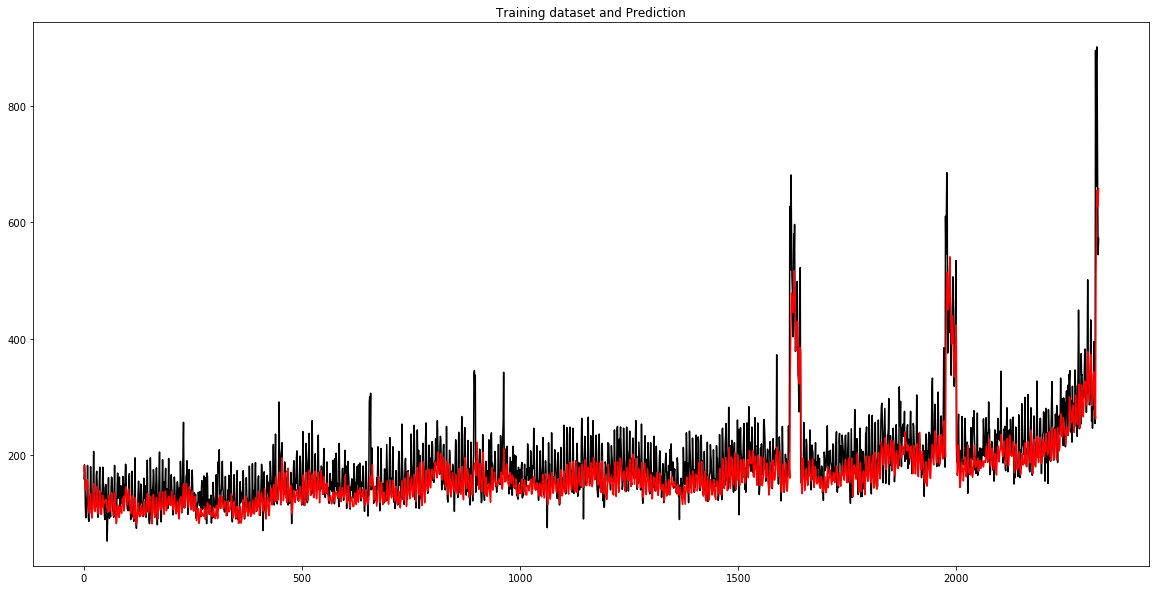

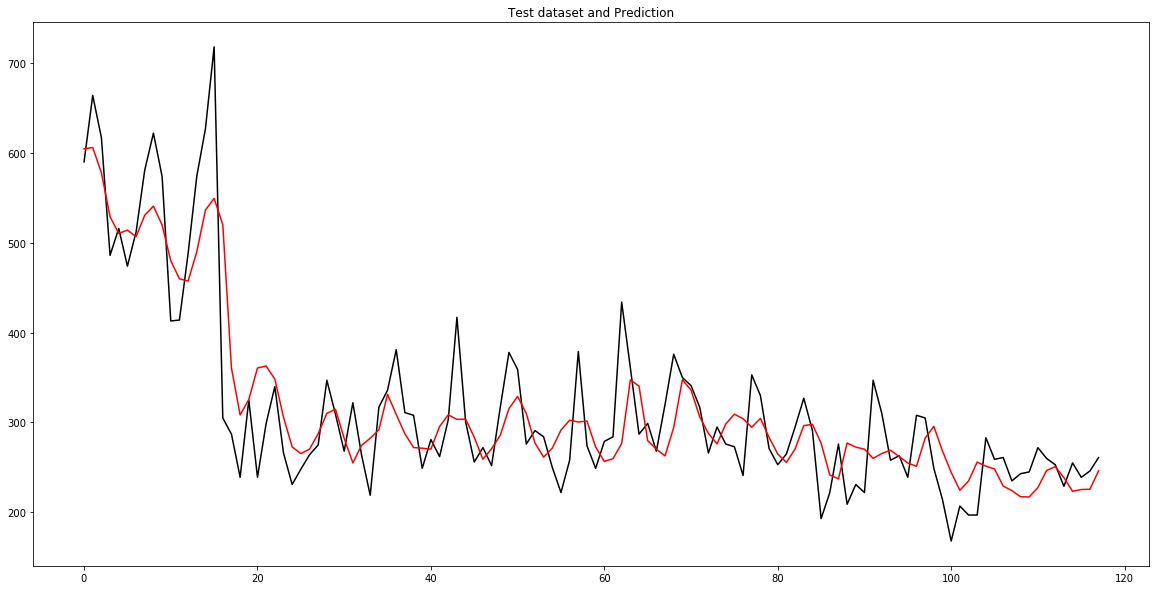

In [13]:
    if is_train == False:
        model_PLSTM.load_weights('model_plstm_multi_best.hd5')
    
    # plstm预测结果
    
    trainPredict = model_PLSTM.predict(trainX)
    testPredict = model_PLSTM.predict(testX)
    
    trainPredict = feature_inverse_rescaling(trainPredict,0,train_min,train_max)
    trainY_raw = feature_inverse_rescaling(trainY,0,train_min,train_max)
    
    testPredict = feature_inverse_rescaling(testPredict,0,test_min,test_max)
    testY_raw = feature_inverse_rescaling(testY,0,test_min,test_max)
       
    print(trainY_raw.shape, trainPredict.shape)    
    trainScore = np.mean(abs((trainY_raw[0]-trainPredict[:,0])/trainY_raw[0]))
    print('Train Score: %.3f MAPE' % (trainScore))
    
    print(testY_raw.shape, testPredict.shape)
    testScore = np.mean(abs((testY_raw[0]-testPredict[:,0])/testY_raw[0]))
    print('Test Score: %.3f MAPE' % (testScore))
        
    # plot baseline and predictions    
    plt.figure(figsize=(20, 10))
    plt.title('Training dataset and Prediction')
    plt.plot(trainY_raw, color='k', label='TRUE')
    plt.plot(trainPredict, color='r', label='PRED')

    plt.show()
    
    
    # plot baseline and predictions    
    plt.figure(figsize=(20, 10))
    plt.title('Test dataset and Prediction')
    plt.plot(testY_raw, color='k', label='TRUE')
    plt.plot(testPredict, color='r', label='PRED')

    plt.show()

Train Score: 0.186 MAPE
Test Score: 0.505 MAPE


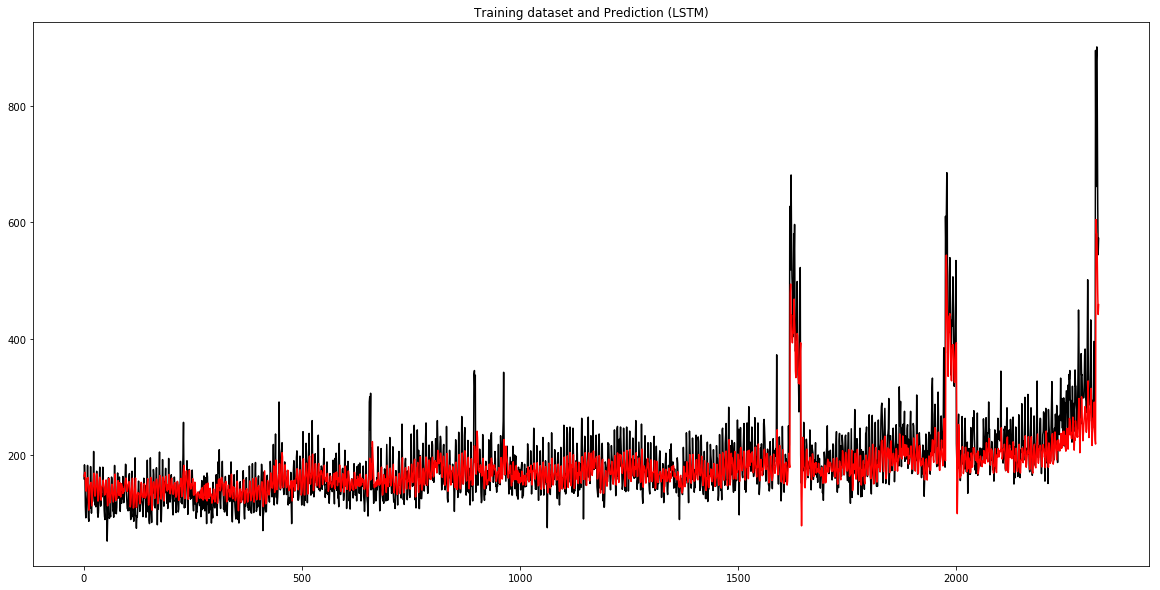

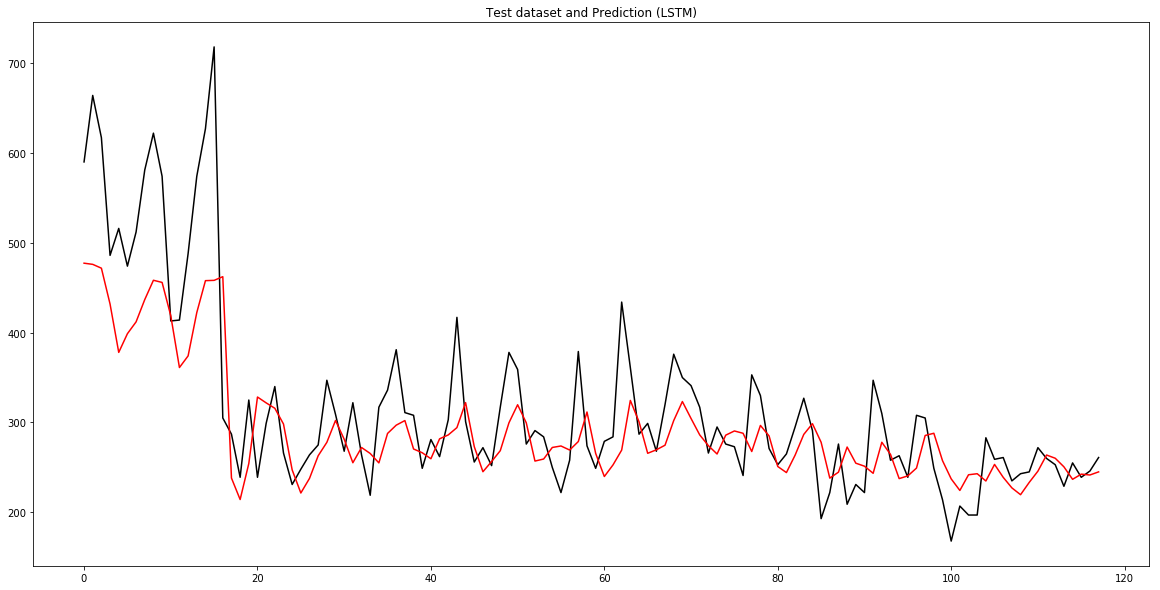

In [14]:
    if is_train == False:
        model_LSTM.load_weights('model_lstm_multi_best.hd5')

    # lstm预测结果
    
    trainPredict = model_LSTM.predict(trainX)
    testPredict = model_LSTM.predict(testX)
    
    trainPredict = feature_inverse_rescaling(trainPredict,0,train_min,train_max)
    
    testPredict = feature_inverse_rescaling(testPredict,0,test_min,test_max)
    
    trainScore = np.mean(abs((trainY_raw[0]-trainPredict[:,0])/trainY_raw[0]))
    print('Train Score: %.3f MAPE' % (trainScore))
    
    testScore = np.mean(abs((testY_raw[0]-testPredict[:,0])/testY_raw[0]))
    print('Test Score: %.3f MAPE' % (testScore))
    
    # plot baseline and predictions    
    plt.figure(figsize=(20, 10))
    plt.title('Training dataset and Prediction (LSTM)')
    plt.plot(trainY_raw, color='k', label='TRUE')
    plt.plot(trainPredict, color='r', label='PRED')

    plt.show()
    
    # plot baseline and predictions    
    plt.figure(figsize=(20, 10))
    plt.title('Test dataset and Prediction (LSTM)')
    plt.plot(testY_raw, color='k', label='TRUE')
    plt.plot(testPredict, color='r', label='PRED')

    plt.show()

(88, 30, 5) (88, 1)
Test Score (lstm): 0.074 MAPE
Test Score (plstm): 0.091 MAPE


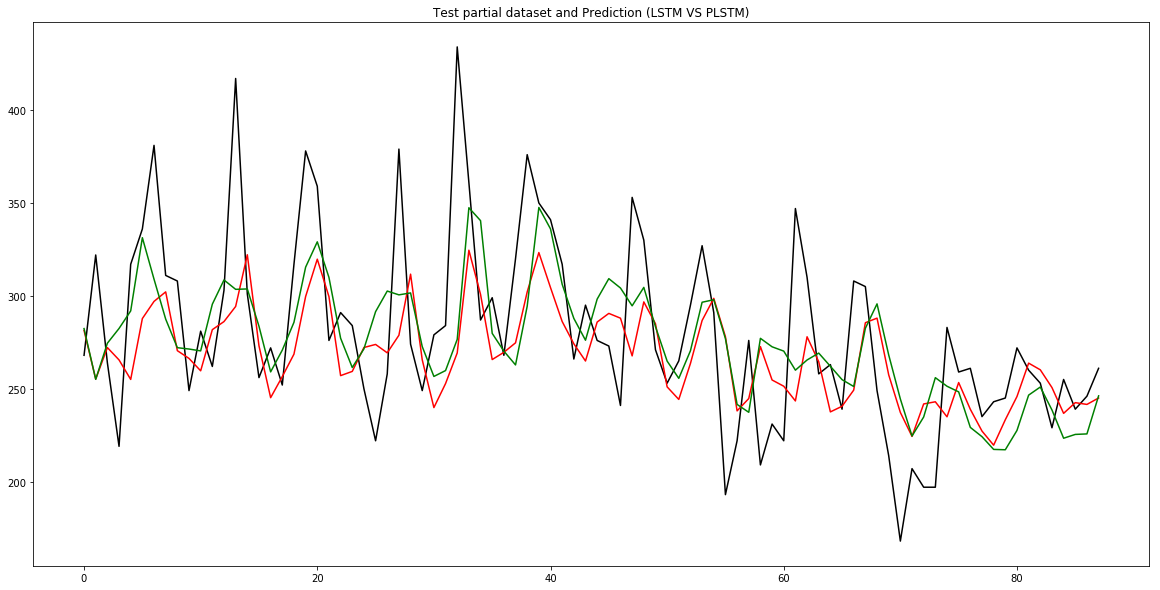

In [15]:
    if is_train == False:
        model_LSTM.load_weights('model_lstm_multi_best.hd5')
        model_PLSTM.load_weights('model_plstm_multi_best.hd5')

    # lstm预测结果 (去掉test前部异常数据)
    
    testX, testY = create_dataset(test, seq_len)
    
    testX = np.reshape(testX, (testX.shape[0], seq_len, testX.shape[2]))
    testY = np.reshape(testY, (testY.shape[0], 1))
    
    print(testX.shape, testY.shape)
        
    testPredict_lstm = model_LSTM.predict(testX)
    testPredict_plstm = model_PLSTM.predict(testX)
    
    testPredict_lstm = feature_inverse_rescaling(testPredict_lstm,0,test_min,test_max)
    testPredict_plstm = feature_inverse_rescaling(testPredict_plstm,0,test_min,test_max)    
    testY_raw = feature_inverse_rescaling(testY,0,test_min,test_max)
    
    testScore_lstm = np.mean(abs((testY_raw[0]-testPredict_lstm[:,0])/testY_raw[0]))
    print('Test Score (lstm): %.3f MAPE' % (testScore_lstm))
    
    testScore_plstm = np.mean(abs((testY_raw[0]-testPredict_plstm[:,0])/testY_raw[0]))
    print('Test Score (plstm): %.3f MAPE' % (testScore_plstm))
    
    # plot baseline and predictions    
    plt.figure(figsize=(20, 10))
    plt.title('Test partial dataset and Prediction (LSTM VS PLSTM)')
    plt.plot(testY_raw, color='k', label='TRUE')
    plt.plot(testPredict_lstm, color='r', label='LSTM_PRED')
    plt.plot(testPredict_plstm, color='g', label='PLSTM_PRED')

    plt.show()

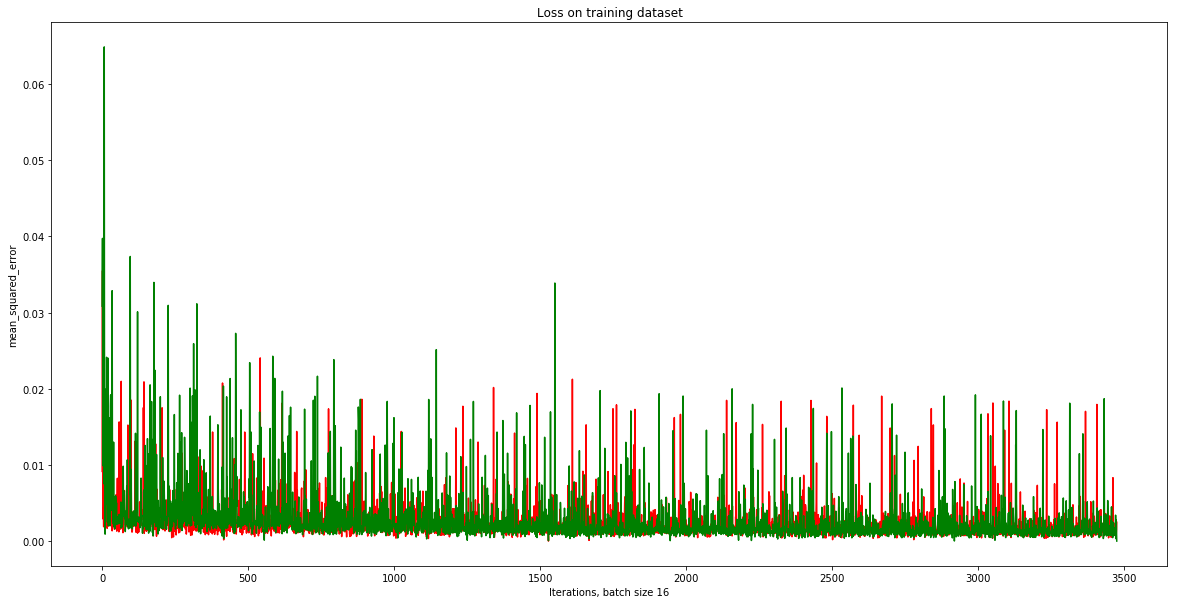

In [16]:
    if is_train:
        plt.figure(figsize=(20, 10))
        plt.title('Loss on training dataset')
        plt.xlabel('Iterations, batch size ' + str(batch_size))
        plt.ylabel('mean_squared_error')
        plt.plot(loss_LSTM.losses, color='r', label='LSTM')
        plt.plot(loss_PLSTM.losses, color='g', label='PLSTM')

        plt.show()

In [17]:
    if False:
        plt.figure(figsize=(20, 10))
        plt.title('Mape on training dataset')
        plt.xlabel('Iterations, batch size ' + str(batch_size))
        plt.ylabel('mape')
        plt.plot(mape_LSTM.losses, color='k', label='LSTM')
        plt.plot(mape_PLSTM.losses, color='r', label='PLSTM')

        plt.show()